# Consignas

1)Desarrollar un sistema de recomendación de prestadores a partir de un modelo K-Nearest Neighbours.

Teniendo en cuenta que el perfil de los pacientes en cada especialidad muestra una marcada diferencia, desarrollar un modelo de recomendación para cada especialidad.
Utilizar modelo sklearn.neighbors.KNeighborsClassifier. La variable target será el id_prestador.
En línea con el objetivo planteado para el proyecto, el dataset de entrenamiento y validación del modelo serán aquellos prestadores que muestran altas calificaciones y un nivel de demanda medio y alto. Las altas calificaciones nos aseguran que los prestadores a recomendar brindan un buen servicio. El nivel de demanda medio/alto nos asegura que las calificaciones son representativas estadísticamente.


# Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
import operator
import scipy as sp
from sklearn.neighbors import KNeighborsClassifier

pd.options.display.float_format = "{:,.4f}".format

# Importación de datasets

In [3]:
df=pd.read_csv('../Data/df_procesado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   int64

In [4]:
df.head(2)

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.6667,1,81,5.7500,1,0,1,...,1,0,0,1,1,0,0,0,0,1
1,2,100000,200000,0.5556,1,81,5.7500,1,0,1,...,1,0,0,1,1,0,0,0,0,1


In [5]:
df.columns

Index(['id_consumo_encoded', 'id_socio_encoded', 'id_prestador_encoded',
       'calificacion_experiencia_encoded', 'id_zona_encoded', 'edad_encoded',
       'antiguedad_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI',
       'especialidad_prestador_encoded_CLINICA MEDICA',
       'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ',
       'especialidad_prestador_encoded_PEDIATRIA', 'edad_cat_0.0',
       'edad_cat_1.0', 'edad_cat_2.0', 'edad_cat_3.0', 'antiguedad_bin_0.0',
       'antiguedad_bin_1.0', 'antiguedad_bin_2.0', 'categoria_prestador_gold',
       'catego

In [6]:
df.rename(columns={'especialidad_prestador_encoded_CLINICA MEDICA':'especialidad_clinica',
                   'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ':'especialidad_nutricion',
                   'especialidad_prestador_encoded_PEDIATRIA':'especialidad_pediatria'},inplace=True)

### Análisis de demanda de prestadores

Verificamos primero que no se repitan los prestadores entre distintas especialidades

In [7]:
prestadores_clinica=df[df.especialidad_clinica==1].id_prestador_encoded.unique()
prestadores_nutricion=df[df.especialidad_nutricion==1].id_prestador_encoded.unique()
prestadores_pediatria=df[df.especialidad_pediatria==1].id_prestador_encoded.unique()

In [8]:
df[(df.especialidad_clinica==1) &
   ((df.id_prestador_encoded.isin(prestadores_nutricion)) | (df.id_prestador_encoded.isin(prestadores_pediatria)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


In [9]:
df[(df.especialidad_nutricion==1) & 
   ((df.id_prestador_encoded.isin(prestadores_clinica)) | (df.id_prestador_encoded.isin(prestadores_pediatria)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


In [10]:
df[(df.especialidad_pediatria==1) & 
   ((df.id_prestador_encoded.isin(prestadores_clinica)) | (df.id_prestador_encoded.isin(prestadores_nutricion)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


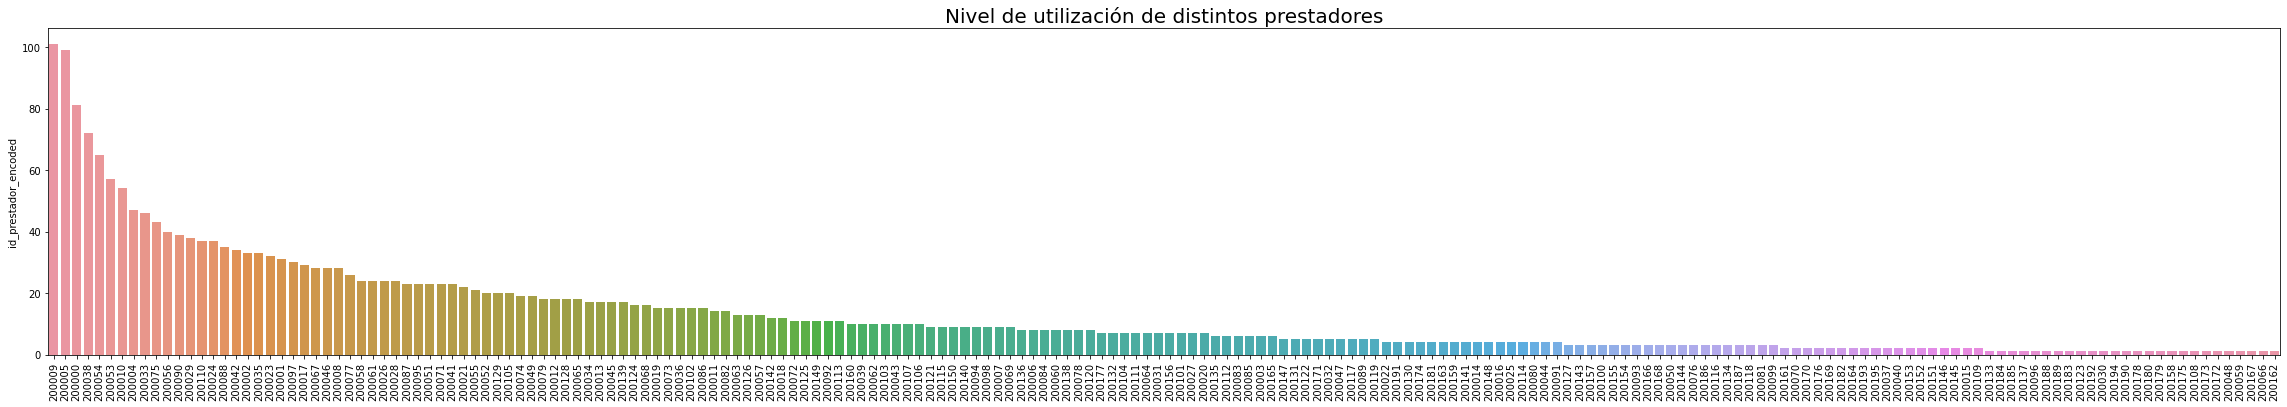

In [11]:
plt.figure(figsize=(40,6))
sns.barplot(x=df.id_prestador_encoded.value_counts().index,y=df.id_prestador_encoded.value_counts(),
           order=df.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores",fontsize=20)
plt.show()

Partiendo del análisis realizado en los laboratorios anteriores, tenemos muchos prestadores que han sido utilizados pocas veces, mientras que hay pocos que han sido utilizados muchas veces.
Vamos a hacer una selección basándonos en medidas de tendencia central de la distribución anterior

In [12]:
df.id_prestador_encoded.value_counts().describe().reset_index()

,index,id_prestador_encoded
0,count,196.0000
1,mean,12.7551
2,std,16.3249
3,min,1.0000
4,25%,3.0000
5,50%,7.0000
6,75%,17.0000
7,max,101.0000


Vamos a filtrar utilizando el percentil 0.42

In [13]:
percetil_42=df.id_prestador_encoded.value_counts().quantile(0.42)
prestadores_interes=df.id_prestador_encoded.value_counts()[df.id_prestador_encoded.value_counts()>percetil_42].index

In [14]:
df_filtrado=df[df.id_prestador_encoded.isin(prestadores_interes)]
df_filtrado.shape

(2272, 37)

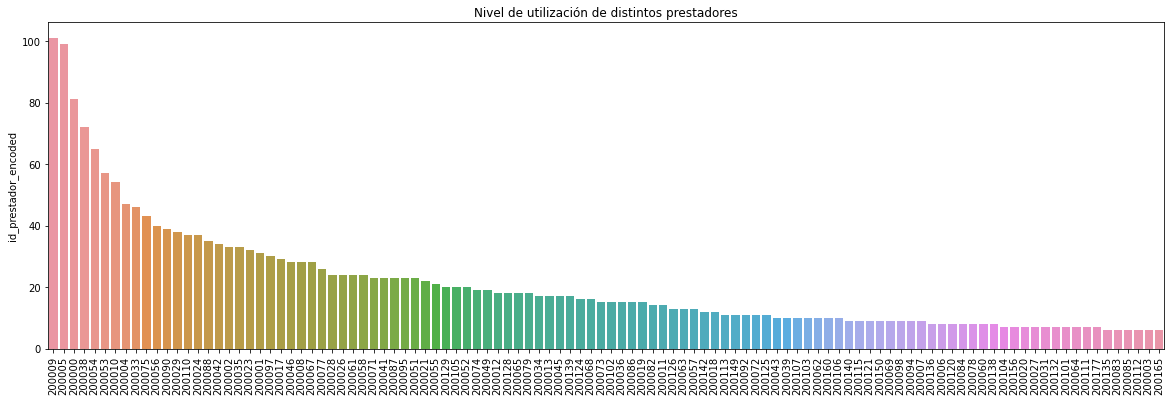

In [15]:
plt.figure(figsize=(20,6))
sns.barplot(x=df_filtrado.id_prestador_encoded.value_counts().index,y=df_filtrado.id_prestador_encoded.value_counts(),
           order=df_filtrado.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores")
plt.show()

### Análisis de calificaciones

C:\Users\silvi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


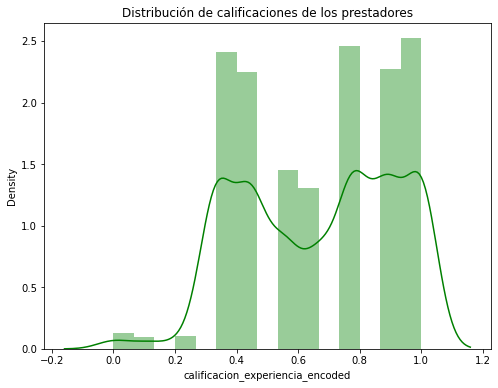

In [16]:
plt.figure(figsize=(8,6))
sns.distplot(df_filtrado.calificacion_experiencia_encoded,color='g')
plt.title("Distribución de calificaciones de los prestadores")
plt.show()

In [17]:
df_filtrado.calificacion_experiencia_encoded.describe().reset_index()

,index,calificacion_experiencia_encoded
0,count,"2,272.0000"
1,mean,0.6647
2,std,0.2486
3,min,0.0000
4,25%,0.4444
5,50%,0.6667
6,75%,0.8889
7,max,1.0000


Vamos a filtrar utilizando el percentil 0.405

In [18]:
percentil_0405=df_filtrado.calificacion_experiencia_encoded.quantile(0.405)

In [19]:
df_filtrado=df_filtrado[df_filtrado.calificacion_experiencia_encoded>percentil_0405]

In [20]:
df_filtrado.shape

(1297, 37)

Nos quedamos con un total de 1297 registros de pacientes para las 3 especialidades. Este grupo de datos considera a los prestadores mas demandados y que posean calificaciones más aceptables.

## Filtrado de variables no importantes

En un primer análisis se tendrán en cuenta todas las variables adicionales. Solamente se quitarán las que no son necesarias para el proceso de modelado

In [21]:
df_filtrado.columns

Index(['id_consumo_encoded', 'id_socio_encoded', 'id_prestador_encoded',
       'calificacion_experiencia_encoded', 'id_zona_encoded', 'edad_encoded',
       'antiguedad_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI', 'especialidad_clinica',
       'especialidad_nutricion', 'especialidad_pediatria', 'edad_cat_0.0',
       'edad_cat_1.0', 'edad_cat_2.0', 'edad_cat_3.0', 'antiguedad_bin_0.0',
       'antiguedad_bin_1.0', 'antiguedad_bin_2.0', 'categoria_prestador_gold',
       'categoria_prestador_silver', 'categoria_prestador_standard',
       'categoria_socio_gold', 'categoria_socio_silver',
    

In [22]:
df_filtrado.drop(['id_consumo_encoded','edad_encoded','id_zona_encoded','antiguedad_encoded','calificacion_experiencia_encoded'],axis=1,inplace=True)

## Especialidad Clínica Médica

Filtramos los prestadores según la especialidad clínica médica

In [26]:
df_clinica=df_filtrado[df_filtrado['especialidad_clinica']==1]
df_clinica.drop(['especialidad_clinica',
       'especialidad_nutricion',
       'especialidad_pediatria',
       'categoria_prestador_gold', 'categoria_prestador_silver',
       'categoria_prestador_standard', 'categoria_socio_gold',
       'categoria_socio_silver', 'categoria_socio_standard'],axis=1,inplace=True)

In [23]:
df_clinica

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
0,100000,200000,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,1
2,100002,200000,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
3,100010,200000,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,100017,200000,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
7,100035,200000,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,101492,200129,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2257,101682,200129,1,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
2258,101696,200129,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2259,101710,200129,1,0,1,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,1


Existen varios registros de los mismos pacientes para un mismo médico, por lo cual vamos a eliminar estos duplicados

In [24]:
df_clinica[df_clinica.id_socio_encoded.duplicated()]

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
15,100332,200000,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
27,100610,200000,1,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
67,101460,200000,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
71,101475,200000,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
87,100594,200001,0,1,0,0,1,1,0,0,...,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,101062,200071,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
1585,101784,200071,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
1955,100791,200097,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
2251,101097,200129,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0


Tenemos 80 registros de pacientes que se corresponden con los mismos pacientes y que por lo tanto deben ser eliminados para no sesgar el modelo. A continuación obtenemos los ids y evaluamos cada uno de los registros para obtener un registro representativo de cada uno de sus consumos.

In [25]:
ids_socios_duplicados=df_clinica[df_clinica.id_socio_encoded.duplicated()].sort_values('id_socio_encoded').id_socio_encoded.unique()
df_duplicados=df_clinica[df_clinica.id_socio_encoded.isin(ids_socios_duplicados)]

In [26]:
df_duplicados

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
14,100332,200000,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
15,100332,200000,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
26,100610,200000,1,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
27,100610,200000,1,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
66,101460,200000,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,100791,200097,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
2250,101097,200129,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
2251,101097,200129,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0
2252,101263,200129,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,1,0


In [27]:
print("Hay {} pacientes con registros duplicados".format(ids_socios_duplicados.shape[0]))

Hay 64 pacientes con registros duplicados


In [28]:
df_clinica=df_clinica.drop_duplicates()

Finalmente vamos a quitar la variable id_socio_encoded

In [29]:
df_clinica.drop(['id_socio_encoded'],axis=1,inplace=True)

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
df_clinica

,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
0,200000,1,0,1,0,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,1
2,200000,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,200000,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4,200000,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
7,200000,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,200129,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2257,200129,1,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1
2258,200129,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2259,200129,1,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1


### Proporción de las clases

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


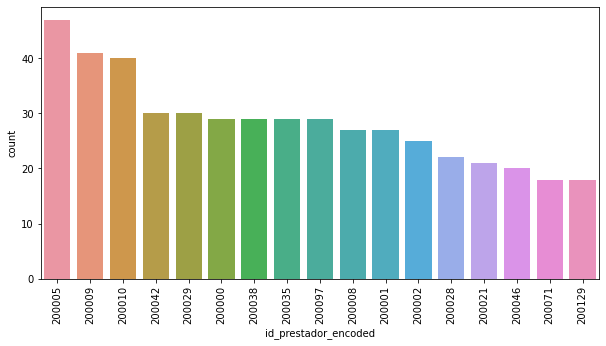

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(df_clinica.id_prestador_encoded,order=df_clinica.id_prestador_encoded.value_counts().index)
plt.xticks(rotation=90)
plt.show()

No existe una desproporción en las clases como tal, por lo cual no será necesario un balanceo.

### División del dataframe en entrenamiento y validación

In [32]:
X=df_clinica.drop(['id_prestador_encoded'],axis=1)
y=df_clinica.id_prestador_encoded

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)

### Modelado y optimización de hiperparámetros

Vamos a hacer un GridSearch con CV, buscando la combinación de hiperparámetros que arroje mejores resultados para la métrica elegida (accuracy score)

In [33]:
dt = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')
rf=RandomForestClassifier(random_state=0,class_weight='balanced')
knn_clf=KNeighborsClassifier()

models_parameters= {'decision_tree': (dt,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__criterion': ['gini','entropy']})
                       ,'randonforest': (rf,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__n_estimators':[50,100,150,200,300],
                      'estimator__criterion': ['gini','entropy']})
                        ,'kneighbors': (knn_clf,
                     {'estimator__n_neighbors':[3,5,10],
                        'estimator__weights':['uniform','distance'],
                        'estimator__metric':['euclidean','manhattan','minkowski']})
                   }

In [34]:
for name, (model, params) in models_parameters.items():

    model_to_set = OneVsRestClassifier(model)

    gs=GridSearchCV(model_to_set,params,n_jobs=-1,cv=5,scoring='f1_macro')

    gs.fit(X_train,y_train)
    
    print(name)
    print(gs.best_score_)
    print(gs.best_params_)

decision_tree
0.11254131489425605
{'estimator__criterion': 'gini', 'estimator__max_depth': 10}
randonforest
0.1167554882843537
{'estimator__criterion': 'gini', 'estimator__max_depth': 4, 'estimator__n_estimators': 100}
kneighbors
0.08865054106540174
{'estimator__metric': 'euclidean', 'estimator__n_neighbors': 5, 'estimator__weights': 'uniform'}


### Mejores resultados y mejores parámetros

### Validación

In [35]:
best_model = RandomForestClassifier(criterion= 'gini', max_depth=4, n_estimators=100,random_state=42)

model_to_set = OneVsRestClassifier(best_model)

model_to_set.fit(X_train,y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=4,
                                                     random_state=42))

In [36]:
y_pred_train=model_to_set.predict(X_train)
y_pred_test=model_to_set.predict(X_test)

In [37]:
y_pred_test_proba=model_to_set.predict_proba(X_test)

In [38]:
predicciones=pd.DataFrame(np.hstack((y_test.values.reshape(-1,1),y_pred_test.reshape(-1,1)))).rename(columns={0:'y_test',1:'y_pred_test'})

In [39]:
pd.DataFrame(classification_report(y_test,y_pred_test, output_dict=True)).T

C:\Users\arrua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
200000,0.0000,0.0000,0.0000,3.0000
200001,0.0000,0.0000,0.0000,3.0000
200002,0.4000,1.0000,0.5714,2.0000
200005,0.1818,0.4000,0.2500,5.0000
200008,0.0000,0.0000,0.0000,3.0000
200009,0.1429,0.2500,0.1818,4.0000
200010,0.2000,0.2500,0.2222,4.0000
200021,0.0000,0.0000,0.0000,2.0000
200028,0.0000,0.0000,0.0000,2.0000
200029,0.2500,0.3333,0.2857,3.0000


In [40]:
cms=multilabel_confusion_matrix(y_test,y_pred_test,labels=y_test.unique())

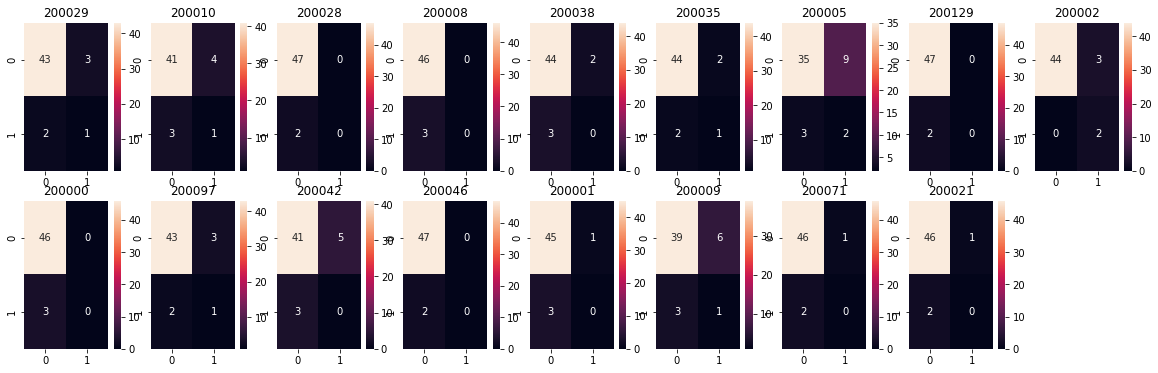

In [41]:
fig,axs=plt.subplots(nrows=2,ncols=9,figsize=(20,6))

j=0
i=0

for cm in range(0,len(cms),1):
    
    sns.heatmap(cms[cm],annot=True,ax=axs[i,j])
    axs[i,j].set_title(y_test.unique()[cm])
    axs[1,8].set_axis_off()
    
    j=j+1
    
    if j==9:
        j=0
        i=i+1
    
    

In [42]:
predicciones[predicciones.y_test==200010]

,y_test,y_pred_test
1,200010,200029
5,200010,200010
17,200010,200038
46,200010,200009


In [43]:
predicciones[predicciones.y_pred_test==200010]

,y_test,y_pred_test
5,200010,200010
13,200008,200010
26,200005,200010
29,200005,200010
47,200042,200010


Luego de analizar las métricas globales y las matrices de confusión de cada una de las clases, podemos concluir con que los resultados de la clasificación no son buenos. El mejor modelo ha logrado clasificar de manera correcta unicamente para las clases 200010,2000029,200035,200005,200002,200097,200009. Por ejemplo, para el prestador 200010 solamente se clasificó bien una vez, hay 3 falsos negativos y ucuatro falsos positivos. El mejor f1-score se obtuvo para la clase 200002. 

## Especialidad Nutrición

Filtramos los prestadores según la especialidad nutrición

In [44]:
df_nutricion=df_filtrado[df_filtrado['especialidad_nutricion']==1]
df_nutricion.drop(['especialidad_clinica',
       'especialidad_nutricion',
       'especialidad_pediatria',
       'categoria_prestador_gold', 'categoria_prestador_silver',
       'categoria_prestador_standard', 'categoria_socio_gold',
       'categoria_socio_silver', 'categoria_socio_standard'],axis=1,inplace=True)

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [45]:
df_nutricion

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
151,100005,200004,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
152,100025,200004,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
153,100052,200004,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
154,100129,200004,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
155,100129,200004,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,101452,200095,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1935,101468,200095,0,1,0,1,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
1936,101737,200095,1,0,0,0,1,1,0,0,...,1,0,1,0,0,0,1,0,0,1
1937,101855,200095,1,0,0,1,0,0,0,0,...,1,0,1,1,0,0,0,0,1,0


Existen varios registros de los mismos pacientes para un mismo médico, por lo cual vamos a eliminar estos duplicados

In [46]:
df_nutricion[df_nutricion.id_socio_encoded.duplicated()]

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
155,100129,200004,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
158,100423,200004,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
159,100423,200004,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
166,100741,200004,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
174,100936,200004,1,0,1,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,100965,200095,0,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1931,100966,200095,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
1933,101452,200095,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1934,101452,200095,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


Tenemos 80 registros de pacientes que se corresponden con los mismos pacientes y que por lo tanto deben ser eliminados para no sesgar el modelo. A continuación obtenemos los ids y evaluamos cada uno de los registros para obtener un registro representativo de cada uno de sus consumos.

In [47]:
ids_socios_duplicados=df_nutricion[df_nutricion.id_socio_encoded.duplicated()].sort_values('id_socio_encoded').id_socio_encoded.unique()
df_duplicados=df_nutricion[df_nutricion.id_socio_encoded.isin(ids_socios_duplicados)]

In [48]:
df_duplicados

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
154,100129,200004,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
155,100129,200004,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
157,100423,200004,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
158,100423,200004,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
159,100423,200004,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,101452,200095,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1933,101452,200095,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1934,101452,200095,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1937,101855,200095,1,0,0,1,0,0,0,0,...,1,0,1,1,0,0,0,0,1,0


In [49]:
print("Hay {} pacientes con registros duplicados".format(ids_socios_duplicados.shape[0]))

Hay 103 pacientes con registros duplicados


In [50]:
df_nutricion=df_nutricion.drop_duplicates()

Finalmente vamos a quitar la variable id_socio_encoded

In [51]:
df_nutricion.drop(['id_socio_encoded'],axis=1,inplace=True)

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [52]:
df_nutricion

,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
151,200004,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
152,200004,1,0,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
153,200004,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
154,200004,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
156,200004,1,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,200095,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
1932,200095,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
1935,200095,0,1,0,1,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
1936,200095,1,0,0,0,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1


### Proporción de las clases

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


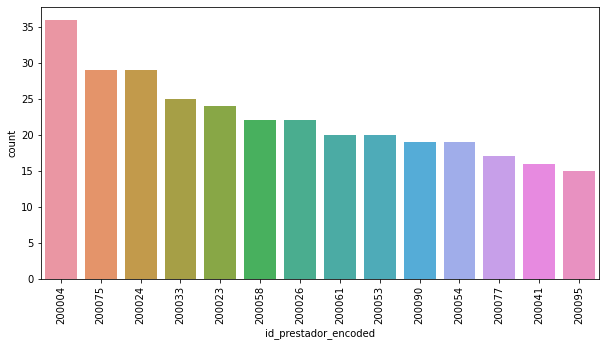

In [53]:
plt.figure(figsize=(10,5))
sns.countplot(df_nutricion.id_prestador_encoded,order=df_nutricion.id_prestador_encoded.value_counts().index)
plt.xticks(rotation=90)
plt.show()

Tampoco una desproporción en las clases como tal, por lo cual no será necesario un balanceo.

### División del dataframe en entrenamiento y validación

In [54]:
X=df_nutricion.drop(['id_prestador_encoded'],axis=1)
y=df_nutricion.id_prestador_encoded

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)

### Modelado y optimización de hiperparámetros

Vamos a hacer un GridSearch con CV, buscando la combinación de hiperparámetros que arroje mejores resultados para la métrica elegida (accuracy score)

In [55]:
dt = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')
rf=RandomForestClassifier(random_state=0,class_weight='balanced')
knn_clf=KNeighborsClassifier()

models_parameters= {'decision_tree': (dt,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__criterion': ['gini','entropy']})
                       ,'randonforest': (rf,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__n_estimators':[50,100,150,200,300],
                      'estimator__criterion': ['gini','entropy']})
                        ,'kneighbors': (knn_clf,
                     {'estimator__n_neighbors':[3,5,10],
                        'estimator__weights':['uniform','distance'],
                        'estimator__metric':['euclidean','manhattan','minkowski']})
                   }

In [56]:
for name, (model, params) in models_parameters.items():

    model_to_set = OneVsRestClassifier(model)

    gs=GridSearchCV(model_to_set,params,n_jobs=-1,cv=5,scoring='f1_macro')

    gs.fit(X_train,y_train)
    
    print(name)
    print(gs.best_score_)
    print(gs.best_params_)

decision_tree
0.1000779379350808
{'estimator__criterion': 'entropy', 'estimator__max_depth': 10}
randonforest
0.14889454149958353
{'estimator__criterion': 'gini', 'estimator__max_depth': 15, 'estimator__n_estimators': 100}
kneighbors
0.11746095174666601
{'estimator__metric': 'manhattan', 'estimator__n_neighbors': 10, 'estimator__weights': 'distance'}


### Mejores resultados y mejores parámetros

### Validación

In [57]:
best_model = RandomForestClassifier(criterion= 'gini', max_depth=15, n_estimators=100,random_state=42)

model_to_set = OneVsRestClassifier(best_model)

model_to_set.fit(X_train,y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=15,
                                                     random_state=42))

In [58]:
y_pred_train=model_to_set.predict(X_train)
y_pred_test=model_to_set.predict(X_test)

In [59]:
predicciones_nutricion=pd.DataFrame(np.hstack((y_test.values.reshape(-1,1),y_pred_test.reshape(-1,1)))).rename(columns={0:'y_test',1:'y_pred_test'})

In [60]:
pd.DataFrame(classification_report(y_test,y_pred_test, output_dict=True)).T

C:\Users\arrua\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
200004,0.0000,0.0000,0.0000,4.0000
200023,0.2000,0.5000,0.2857,2.0000
200024,0.0000,0.0000,0.0000,3.0000
200026,0.2000,0.5000,0.2857,2.0000
200033,0.0000,0.0000,0.0000,3.0000
200041,0.0000,0.0000,0.0000,2.0000
200053,0.2000,0.5000,0.2857,2.0000
200054,0.0000,0.0000,0.0000,2.0000
200058,0.0000,0.0000,0.0000,2.0000
200061,1.0000,0.5000,0.6667,2.0000


Las métricas globales no son las mejores. El modelo no clasifica correctamente para los prestadores.-

In [61]:
from sklearn.metrics import multilabel_confusion_matrix

cms = multilabel_confusion_matrix(y_test,y_pred_test,labels=y_test.unique())

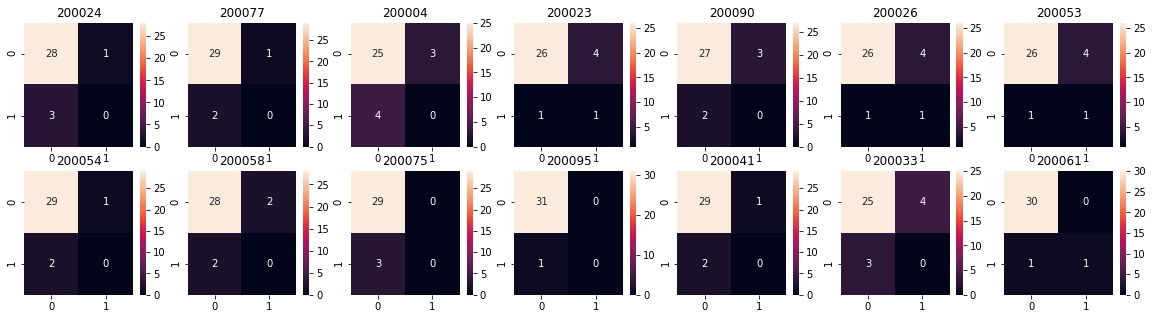

In [62]:
fig,axs=plt.subplots(nrows=2,ncols=7,figsize=(20,5))

j=0
i=0

for cm in range(0,len(cms),1):
    
    sns.heatmap(cms[cm],annot=True,ax=axs[i,j])
    axs[i,j].set_title(y_test.unique()[cm])
    
    j=j+1
    
    if j==7:
        j=0
        i=i+1
    
    

In [63]:
predicciones_nutricion[predicciones_nutricion.y_test==200023]

,y_test,y_pred_test
3,200023,200026
14,200023,200023


In [64]:
predicciones_nutricion[predicciones_nutricion.y_pred_test==200023]

,y_test,y_pred_test
10,200054,200023
12,200004,200023
14,200023,200023
28,200033,200023
31,200041,200023


Con las matrices de confusión podemos observar que los resultados de la clasificación no son los mejores en casi todas las clases. Solamente se ha clasificado correctamente para 4 clases (200023,200053,200061,200026), habiendo en casi todas ellas varios FN y FP, como lo indican las métricas de precisión y sensibilidad. Donde se tiene mejor F1-score es con la clase 200061, que es donde mejor se ha clasificado teniendo en cuenta por supuesto el número de registros disponibles para esta clase.

## Especialidad Pediatria

In [25]:
df_pediatria=df_filtrado[df_filtrado['especialidad_pediatria']==1]
df_pediatria.drop(['especialidad_clinica',
       'especialidad_nutricion',
       'especialidad_pediatria',
       'categoria_prestador_gold', 'categoria_prestador_silver',
       'categoria_prestador_standard', 'categoria_socio_gold',
       'categoria_socio_silver', 'categoria_socio_standard'],axis=1,inplace=True)

In [27]:
df_pediatria

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
556,100033,200017,1,0,1,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
557,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
558,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
559,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
560,100217,200017,0,1,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,101868,200110,1,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,1,0
2100,101869,200110,1,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,1,0
2101,101869,200110,1,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,1,0
2102,101901,200110,0,1,0,1,0,1,0,0,...,1,0,1,1,0,0,0,0,1,0


In [28]:
df_pediatria[df_pediatria.id_socio_encoded.duplicated()]

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
558,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
559,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
561,100217,200017,0,1,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
562,100217,200017,0,1,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
566,100449,200017,1,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,101363,200110,0,1,1,0,0,0,0,1,...,1,0,1,1,0,0,0,0,1,0
2091,101379,200110,0,1,0,0,1,0,0,1,...,1,0,1,1,0,0,0,1,0,0
2093,101467,200110,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2094,101467,200110,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1


Tenemos 85 registros de pacientes que se corresponden con los mismos pacientes y que por lo tanto deben ser eliminados para no sesgar el modelo. A continuación obtenemos los ids y evaluamos cada uno de los registros para obtener un registro representativo de cada uno de sus consumos.

In [29]:
ids_socios_duplicados=df_pediatria[df_pediatria.id_socio_encoded.duplicated()].sort_values('id_socio_encoded').id_socio_encoded.unique()
df_duplicados=df_pediatria[df_pediatria.id_socio_encoded.isin(ids_socios_duplicados)]

In [30]:
df_duplicados

,id_socio_encoded,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
557,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
558,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
559,100216,200017,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
560,100217,200017,0,1,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
561,100217,200017,0,1,1,0,0,1,0,0,...,1,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,101467,200110,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2093,101467,200110,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2094,101467,200110,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2100,101869,200110,1,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,1,0


In [31]:
print("Hay {} pacientes con registros duplicados".format(ids_socios_duplicados.shape[0]))

Hay 50 pacientes con registros duplicados


In [32]:
df_pediatria=df_pediatria.drop_duplicates()

In [33]:
df_pediatria.drop(['id_socio_encoded'],axis=1,inplace=True)

C:\Users\silvi\anaconda3\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
df_pediatria

,id_prestador_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_empresa_tipo_2,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,...,parentesco_encoded_Titular,app_descargada_encoded_NO,app_descargada_encoded_SI,edad_cat_0.0,edad_cat_1.0,edad_cat_2.0,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0
556,200017,1,0,1,0,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
557,200017,1,0,1,0,0,1,0,0,0,...,1,0,1,1,0,0,0,1,0,0
560,200017,0,1,1,0,0,1,0,0,0,...,1,0,1,1,0,0,0,1,0,0
563,200017,0,1,1,0,0,0,1,0,0,...,1,0,1,1,0,0,0,0,1,0
564,200017,0,1,1,0,0,1,0,0,0,...,1,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,200110,0,1,1,0,0,0,0,0,1,...,1,0,1,1,0,0,0,1,0,0
2099,200110,1,0,1,0,0,0,0,0,1,...,1,0,1,1,0,0,0,0,1,0
2100,200110,1,0,1,0,0,0,0,0,1,...,1,0,1,1,0,0,0,0,1,0
2102,200110,0,1,0,1,0,1,0,0,0,...,1,0,1,1,0,0,0,0,1,0


### Proporción de las clases

C:\Users\silvi\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


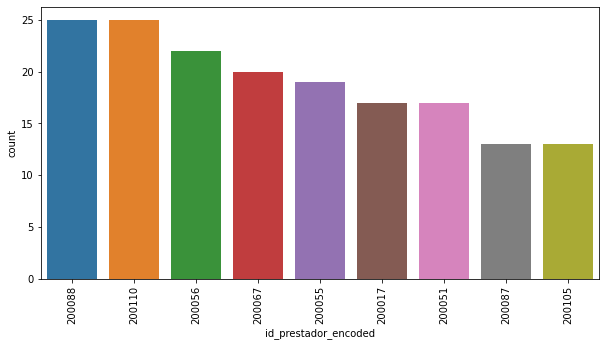

In [35]:
plt.figure(figsize=(10,5))
sns.countplot(df_pediatria.id_prestador_encoded,order=df_pediatria.id_prestador_encoded.value_counts().index)
plt.xticks(rotation=90)
plt.show()

### División del dataframe en entrenamiento y validación

In [36]:
X=df_pediatria.drop(['id_prestador_encoded'],axis=1)
y=df_pediatria.id_prestador_encoded

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)

### Modelado y optimización de hiperparámetros

In [37]:
dt = DecisionTreeClassifier(random_state = 0 , class_weight = 'balanced')
rf=RandomForestClassifier(random_state=0,class_weight='balanced')
knn_clf=KNeighborsClassifier()

models_parameters= {'decision_tree': (dt,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__criterion': ['gini','entropy']})
                       ,'randonforest': (rf,
                     {'estimator__max_depth': [2,3,4,5,10,15,20,25,30,40,50],
                      'estimator__n_estimators':[50,100,150,200,300],
                      'estimator__criterion': ['gini','entropy']})
                        ,'kneighbors': (knn_clf,
                     {'estimator__n_neighbors':[3,5,10],
                        'estimator__weights':['uniform','distance'],
                        'estimator__metric':['euclidean','manhattan','minkowski']})
                   }

In [38]:
for name, (model, params) in models_parameters.items():

    model_to_set = OneVsRestClassifier(model)

    gs=GridSearchCV(model_to_set,params,n_jobs=-1,cv=5,scoring='f1_macro')

    gs.fit(X_train,y_train)
    
    print(name)
    print(gs.best_score_)
    print(gs.best_params_)

decision_tree
0.138680455347122
{'estimator__criterion': 'entropy', 'estimator__max_depth': 5}
randonforest
0.18071027737694406
{'estimator__criterion': 'gini', 'estimator__max_depth': 4, 'estimator__n_estimators': 100}
kneighbors
0.14834535834535836
{'estimator__metric': 'euclidean', 'estimator__n_neighbors': 10, 'estimator__weights': 'uniform'}


### Mejores resultados y mejores parámetros

### Validación

In [39]:
best_model = RandomForestClassifier(criterion= 'gini', max_depth=4, n_estimators=100,random_state=42)

model_to_set = OneVsRestClassifier(best_model)

model_to_set.fit(X_train,y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=4,
                                                     random_state=42))

In [40]:
y_pred_train=model_to_set.predict(X_train)
y_pred_test=model_to_set.predict(X_test)

In [41]:
predicciones_pediatria=pd.DataFrame(np.hstack((y_test.values.reshape(-1,1),y_pred_test.reshape(-1,1)))).rename(columns={0:'y_test',1:'y_pred_test'})

In [42]:
pd.DataFrame(classification_report(y_test,y_pred_test, output_dict=True)).T

C:\Users\silvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\silvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\silvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
200017,0.0000,0.0000,0.0000,2.0000
200051,0.0000,0.0000,0.0000,2.0000
200055,0.0000,0.0000,0.0000,2.0000
200056,0.1429,0.5000,0.2222,2.0000
200067,0.0000,0.0000,0.0000,2.0000
200087,0.0000,0.0000,0.0000,1.0000
200088,0.0000,0.0000,0.0000,3.0000
200105,0.0000,0.0000,0.0000,1.0000
200110,0.0000,0.0000,0.0000,3.0000
accuracy,0.0556,0.0556,0.0556,0.0556


In [43]:
from sklearn.metrics import multilabel_confusion_matrix

cms = multilabel_confusion_matrix(y_test,y_pred_test,labels=y_test.unique())

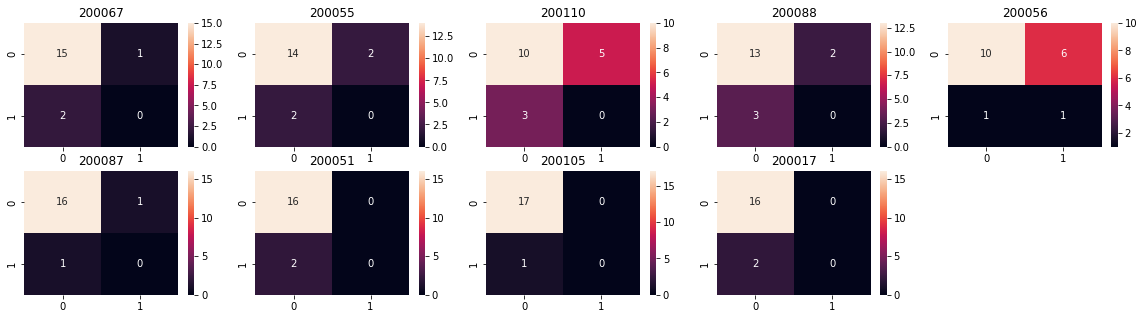

In [47]:
fig,axs=plt.subplots(nrows=2,ncols=5,figsize=(20,5))

j=0
i=0

for cm in range(0,len(cms),1):
    
    sns.heatmap(cms[cm],annot=True,ax=axs[i,j])
    axs[i,j].set_title(y_test.unique()[cm])
    axs[1,4].set_axis_off()
    
    j=j+1
    
    if j==5:
        j=0
        i=i+1
    
    

Con las matrices de confusión podemos observar que los resultados de la clasificación no son los mejores en casi todas las clases. Solamente se ha clasificado correctamente a  1 clase (200056) habiendo en casi todas ellas varios FN y FP, como lo indican las métricas de precisión y sensibilidad. Donde se tiene mejor F1-score es con la clase 200056.

In [49]:
predicciones_pediatria[predicciones_pediatria.y_test==200056]

,y_test,y_pred_test
5,200056,200056
7,200056,200088


In [51]:
predicciones_pediatria[predicciones_pediatria.y_pred_test==200056]

,y_test,y_pred_test
0,200067,200056
2,200110,200056
3,200088,200056
4,200067,200056
5,200056,200056
11,200110,200056
16,200017,200056
